# 95-869: Big Data and Large-Scale Computing Homework 2

<b> Name: Jessie Chia-Hsuan Lee </b>

## **Linear Regression Assignment**
#### This assignment covers a common supervised learning pipeline, using a  modified version of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.
#### ** This assignment will cover: **
*  *Part 1 (6 Points):* Read and parse the initial dataset
  * *Visualization 1 (5 Points):* Features
  * *Visualization 2 (5 Points):* Shifting labels

*  *Part 2 (6 Points):* Create and evaluate a baseline model
  * *Visualization 3 (5 Points):* Predicted vs. actual

*  *Part 3 (15 Points):* Train least squares linear regression (via gradient descent) and evaluate a linear regression model
  * *Visualization 4 (5 Points):* Training error

*  *Part 4 (15 Points):* Train Train least squares linear regression with L2 regularization (via gradient descent) and evaluate a linear regression model
  * *Visualization 5 (5 Points):* Training error

*  *Part 5 (15 Points):* Train using SparkML and tune hyperparameters via grid search
  * *Visualization 6 (5 Points):* Best model's predictions
  * *Visualization 7 (5 Points):* Hyperparameter heat map

*  *Part 6 (8 Points):* Add interactions between features
 
#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Submission Instructions:

You will submit both a PDF and a Jupyter notebook file on Canvas. No printout submission is expected.

You should also submit a PDF through gradescope.

Rename the notebook from "hw2_linear_reg_student.ipynb" to "andrewid_hw2_linear_reg_student.ipynb" where "andrewid" is your group_ID (e.g. group3) or Andrew ID if you only have yourself in your group. Complete the assignment, execute all cells in the completed notebook, and make sure all results show up. Export the contents of the notebook by choosing "File > Download as > HTML" and saving the resulting file as "andrewid_hw2_linear_reg_student.html" Convert the exported HTML file to PDF by using a feature such as the "Save as PDF" feature on Mac. Submit the Jupyter notebook and exported PDF solution files on Canvas. Also submit the PDF solution files to gradescope.

### ** Part 1: Read and parse the initial dataset **

#### ** (1a) Load and check the data **
#### The raw data is currently stored in text file.  We will start by storing this raw data in as an RDD, with each element of the RDD representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Use the [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) to check how many data points we have.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) to create and print out a list of the first 5 data points in their initial string format.

In [1]:
import os
import sys
import os.path
import warnings
warnings.filterwarnings('ignore')

sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.9-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext

conf = SparkConf().setAppName("MyApp").setMaster("local[*]").set("spark.driver.memory", "4g").set("spark.executor.memory", "4g")
sc = SparkContext(conf=conf)
sc

23/04/06 22:33:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local[*] appName=MyApp>

In [2]:
numPartitions = 8
rawData = sc.textFile('file:///ocean/projects/cis220071p/shared/data/millionsong_bigdata.txt', numPartitions)

In [3]:
# TODO: Replace <FILL IN> with appropriate code
numPoints = rawData.count()
print (numPoints)
samplePoints = rawData.take(5)
print (samplePoints)

1015324
['2.00500000e+03,8.00890230e-01,6.56657992e-01,3.25012011e-01,3.88967777e-01,2.59227069e-01,3.51218956e-01,3.55794257e-01,3.50315260e-01,6.40341845e-01,5.62001594e-01,5.95646033e-01,4.98571737e-01', '1.97400000e+03,6.13489242e-01,6.41458028e-01,2.78497062e-01,3.36810765e-01,3.80977949e-01,3.37200764e-01,3.53774994e-01,4.24861111e-01,5.51306540e-01,4.45964685e-01,6.22590106e-01,6.09032474e-01', '1.98700000e+03,8.43599476e-01,6.17139860e-01,5.02508467e-01,4.38770294e-01,3.11464360e-01,3.81006120e-01,4.58850780e-01,4.43217844e-01,6.05648100e-01,4.45977090e-01,5.14609707e-01,4.28761963e-01', '2.00800000e+03,8.77323637e-01,6.72525879e-01,4.71228100e-01,4.33595141e-01,2.79012358e-01,3.51656386e-01,4.67118237e-01,4.72284730e-01,6.34704607e-01,6.01637231e-01,4.91206094e-01,4.04435583e-01', '1.97000000e+03,6.52183301e-01,6.55613002e-01,5.04868026e-01,5.10029804e-01,3.70969860e-01,6.92052424e-01,4.04965750e-01,2.42278423e-01,5.86823050e-01,2.77983946e-01,5.36907965e-01,6.03661483e-01']


#### ** (1b) Using `LabeledPoint` **
#### In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the parsePoint function that takes as input a raw data point, parses it using Python's [unicode.split](https://docs.python.org/2/library/string.html#string.split) method, and returns a `LabeledPoint`.  Use this function to parse samplePoints (from the previous question).  Then print out the features and label for the first training point, using the `LabeledPoint.features` and `LabeledPoint.label` attributes. Finally, calculate the number of features for this dataset.
#### Note that `split()` can be called directly on a `unicode` or `str` object.  For example, `u'split,me'.split(',')` returns `[u'split', u'me']`.

In [4]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint


# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [5]:
# TODO: Replace <FILL IN> with appropriate code
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.

    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.

    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    # split the line into a list of string using comma as the delimiter 
    parts = line.split(',')
    
    # extract the label from the first element of the list    
    label = line.split(',')[0]
    
    # extract the features from the remaining elements of the list
    features = line.split(',')[1:]
    
    return LabeledPoint(label, features)

parsedSamplePoints = list(map(parsePoint, samplePoints))
firstPointFeatures = parsedSamplePoints[0].features
firstPointLabel = parsedSamplePoints[0].label
print (firstPointFeatures, firstPointLabel)

d = len(firstPointFeatures)
print (d)

[0.80089023,0.656657992,0.325012011,0.388967777,0.259227069,0.351218956,0.355794257,0.35031526,0.640341845,0.562001594,0.595646033,0.498571737] 2005.0
12


#### **Visualization 1: Features**
#### First we will load and setup the visualization library.  Then we will look at the raw features for 100 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 100 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

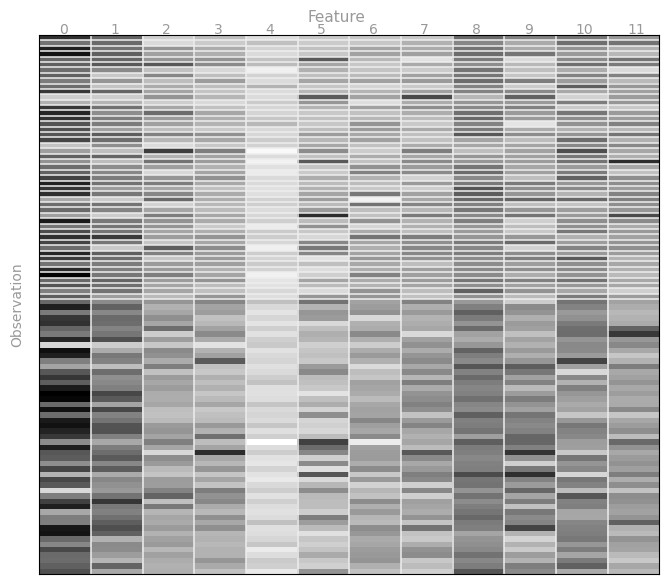

In [6]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

sampleMorePoints = rawData.take(100)
# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell.  Note that you should run this cell with the line commented
# out when answering the lab quiz questions.
# sampleMorePoints = rawData.takeSample(False, 100)

parsedSampleMorePoints = map(parsePoint, sampleMorePoints)
dataValues = list(map(lambda lp: lp.features.toArray(), parsedSampleMorePoints))

def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                     gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(dataValues, interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
plt.show()

#### **(1c) Find the range **
#### Now let's examine the labels to find the range of song years.  To do this, first parse each element of the `rawData` RDD, and then find the smallest and largest labels.

In [7]:
# TODO: Replace <FILL IN> with appropriate code
parsedDataInit = rawData.map(parsePoint)
labels = parsedDataInit.map(lambda lp:lp.label)
minYear = labels.min()
maxYear = labels.max()
print (maxYear, minYear)

2011.0 1922.0


#### **(1d) Shift labels **
#### As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsedDataInit`, create a new RDD consisting of `LabeledPoint` objects in which the labels are shifted such that smallest label equals zero.

In [8]:
# TODO: Replace <FILL IN> with appropriate code
parsedData = parsedDataInit.map(lambda x: LabeledPoint(x.label-minYear, x.features))

# Should be a LabeledPoint
print(type(parsedData.take(1)[0]))
# View the first point
print('\n{0}'.format(parsedData.take(1)))

<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(83.0, [0.80089023,0.656657992,0.325012011,0.388967777,0.259227069,0.351218956,0.355794257,0.35031526,0.640341845,0.562001594,0.595646033,0.498571737])]


#### ** Visualization 2: Shifting labels **
#### We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing i) a label value and ii) the number of training points with this label.  The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

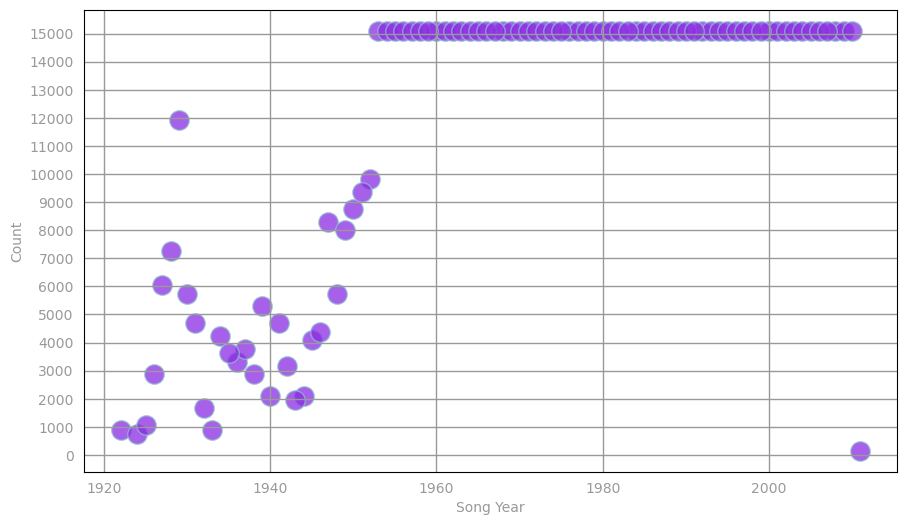

In [9]:
# get data for plot
oldData = (parsedDataInit
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*oldData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(1920, 2050, 20), np.arange(0, 25000, 1000))
plt.scatter(x, y, s=14**2, c='#8A2BE2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Song Year'), ax.set_ylabel('Count')
plt.show()

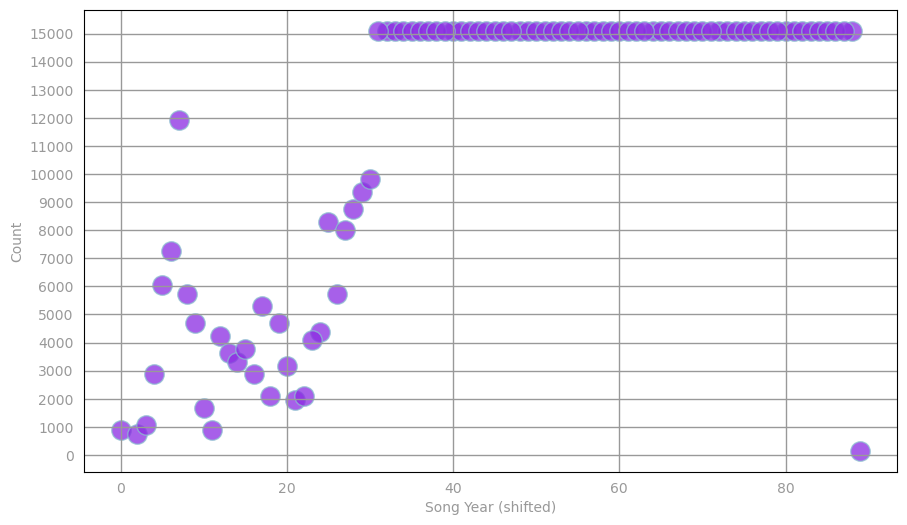

In [10]:
# get data for plot
newData = (parsedData
           .map(lambda lp: (lp.label, 1))
           .reduceByKey(lambda x, y: x + y)
           .collect())
x, y = zip(*newData)

# generate layout and plot data
fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 25000, 1000))
plt.scatter(x, y, s=14**2, c='#8A2BE2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Song Year (shifted)'), ax.set_ylabel('Count')
plt.show()

#### ** (1e) Training, validation, and test sets **
#### We're almost done parsing our dataset, and our final task involves split it into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.randomSplit.html) with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [11]:
# TODO: Replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 0
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print (nTrain, nVal, nTest, nTrain + nVal + nTest)
print (parsedData.count())

812464 101277 101583 1015324


1015324


### ** Part 2: Create and evaluate a baseline model **

#### **(2a) Average label **
#### A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.  Use an appropriate method in the [RDD API](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.html).

In [12]:
# TODO: Replace <FILL IN> with appropriate code
averageTrainYear = (parsedTrainData
                    .map(lambda lp:lp.label)).mean()
print (averageTrainYear)

53.77747567892263


#### **(2b) Root mean squared error **
#### We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [13]:
# TODO: Replace <FILL IN> with appropriate code
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (float(label) - float(prediction))**2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return (labelsAndPreds.map(lambda lp:squaredError(lp[0], lp[1])).mean())**(1/2)

labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print (exampleRMSE)

1.2909944487358056


#### **(2c) Training, validation and test RMSE **
#### Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years).

In [14]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTrain = parsedTrainData.map(lambda lp:(lp.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

labelsAndPredsVal = parsedValData.map(lambda lp:(lp.label, averageTrainYear))
rmseValBase = calcRMSE(labelsAndPredsVal)

labelsAndPredsTest = parsedTestData.map(lambda lp:(lp.label, averageTrainYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print ('Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmseValBase))
print ('Baseline Test RMSE = {0:.3f}'.format(rmseTestBase))

Baseline Train RMSE = 21.420
Baseline Validation RMSE = 21.475
Baseline Test RMSE = 21.349


#### ** Visualization 3: Predicted vs. actual **
#### We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `averageTrainYear`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light red when the true and predicted values are equal to dark purple when they drastically differ.

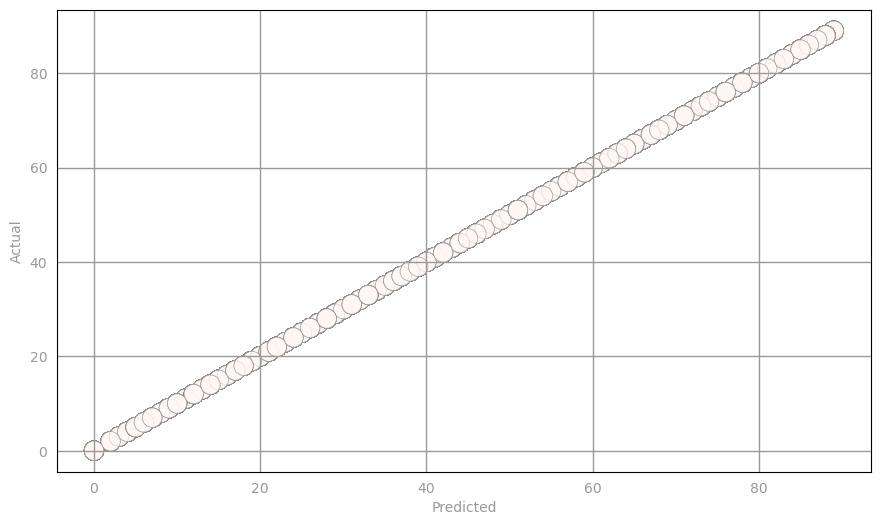

In [15]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('RdPu')
norm = Normalize()

actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: squaredError(lp.label, lp.label))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()

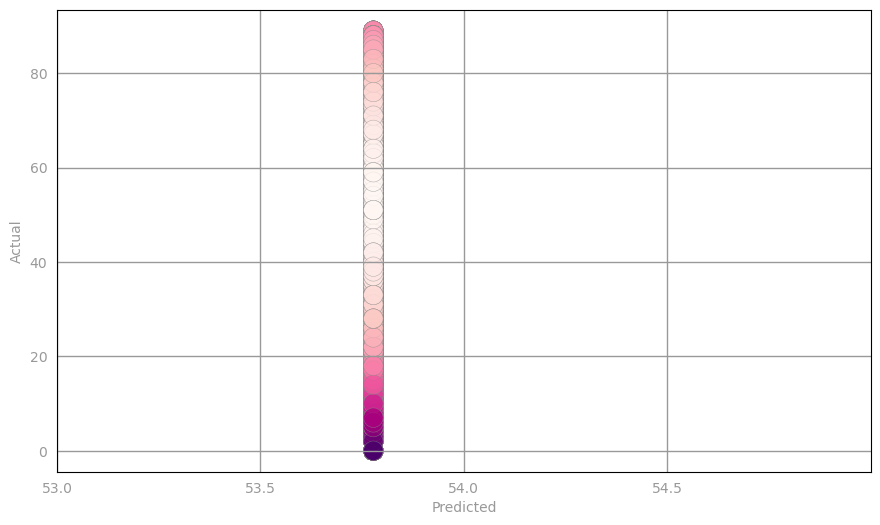

In [16]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: averageTrainYear)
                         .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: squaredError(lp.label, averageTrainYear))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = preparePlot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
plt.show()

### ** Part 3: Train Least Squares Linear Regression (via gradient descent) and evaluate a linear regression model **

#### ** (3a) Gradient summand **
#### Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ where i is the iteration number of the gradient descent algorithm, and  j identifies the observation.
#### First, implement a function that computes the summand for this update, i.e., the summand equals $$ (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$$ and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [17]:
from pyspark.mllib.linalg import DenseVector

In [18]:
# TODO: Replace <FILL IN> with appropriate code
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (weights.dot(lp.features) - lp.label) * (lp.features)

exampleW = DenseVector([1, 2, 1])
exampleLP = LabeledPoint(3.0, [3, 2, 4])
# gradientSummand = (dot([1 2 1], [3 2 4]) - 3) * [3 2 4] = (11 - 3) * [3 2 4] = [24 16 32]
summandOne = gradientSummand(exampleW, exampleLP)
print (summandOne)

exampleW = DenseVector([.24, 1.2, -1.4])
exampleLP = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summandTwo = gradientSummand(exampleW, exampleLP)
print (summandTwo)

[24.0,16.0,32.0]
[1.7303999999999995,-5.191199999999999,-2.5955999999999997]


#### ** (3b) Use weights to make predictions **
#### Next, implement a `getLabeledPredictions` function that takes in weights and an observation's `LabeledPoint` and returns a (label, prediction) tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [19]:
# TODO: Replace <FILL IN> with appropriate code
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return (observation.label, weights.dot(observation.features))

weights = np.array([2.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print (labelsAndPredsExample.collect())

[(2.0, 2.75), (1.5, 1.75)]


#### ** (3c) Gradient descent **
#### Next, implement a gradient descent function for linear regression and test out this function on an example.

In [20]:
# TODO: Replace <FILL IN> with appropriate code
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp:getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp:gradientSummand(w, lp)).sum()

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 5, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 5
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print (exampleData.take(1))
exampleNumIters = 10
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print (exampleWeights)

[LabeledPoint(83.0, [0.80089023,0.656657992,0.325012011,0.388967777,0.259227069])]


[36.28135207 26.29711857 18.19231321 18.93953447 14.64993621]


#### ** (3d) Train the model **
#### Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.
#### We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [21]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData, numIters)

print (weightsLR0)

labelsAndPreds = parsedValData.map(lambda lp:getLabeledPrediction(weightsLR0, lp))
rmseValLR0 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0))

[22.47264988 20.29216854 -0.23045826  8.40112182  5.83350335 -4.42871527
 15.45357794  3.901584    9.92514447  5.91614745 11.16489341  3.67598594]
Validation RMSE:
	Baseline = 21.475
	LR0 = 18.835


#### ** Visualization 4: Training error **
#### We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 45 iterations.

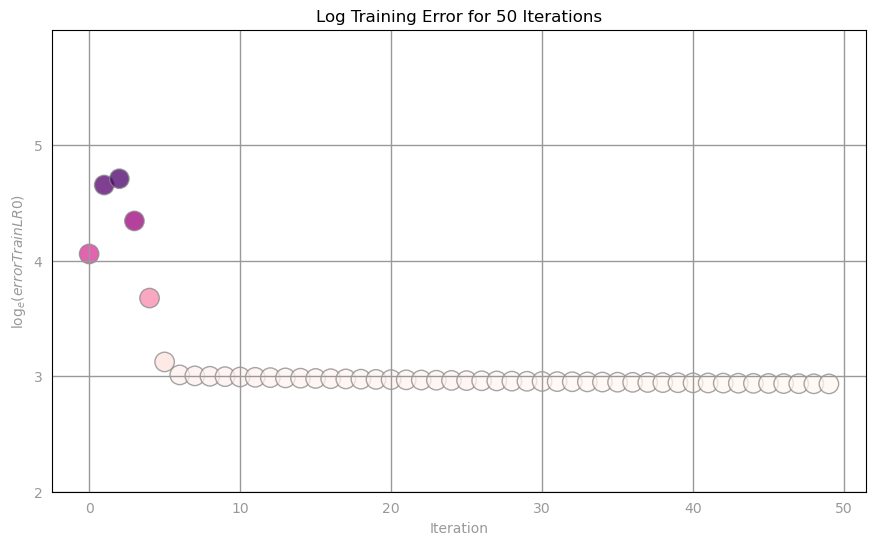

In [22]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainLR0))))[:,0:5]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, numIters), np.log(errorTrainLR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
plt.title("Log Training Error for 50 Iterations")
plt.show()

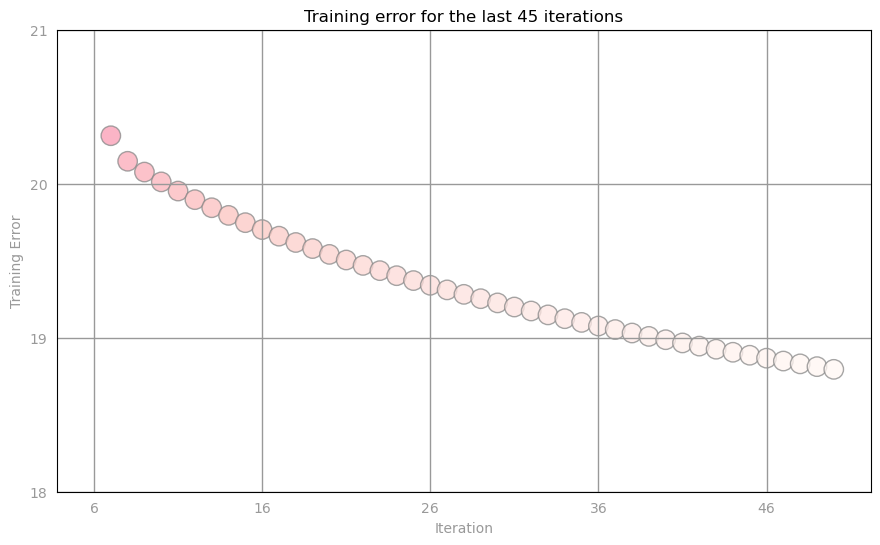

In [23]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[5:])))[:,0:5]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(18, 21)
plt.scatter(range(0, numIters-5), errorTrainLR0[5:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
plt.title("Training error for the last 45 iterations")
plt.show()

### ** Part 4: Train Least Squares Linear Regression with L2 regularization (via gradient descent) and evaluate a linear regression model **

#### ** (4a) Gradient summand **
#### Recall that the gradient descent update for linear regression with L2 regularization is: $$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \left( \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j + \eta \mathbf{w}_i \right) \,.$$ where i is the iteration number of the gradient descent algorithm, and  j identifies the observation.
#### We have already implemented the function gradientSummand that computes the summand for this update, i.e., $$ (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \,$$
#### We have also already implemented the `getLabeledPredictions` function that takes in weights and an observation's `LabeledPoint` and returns a (label, prediction) tuple.

#### ** (4b) Gradient descent with L2 regularization **
#### Next, implement a gradient descent function for linear regression with L2 regularization and test out this function on an example.

In [24]:
# TODO: Replace <FILL IN> with appropriate code
def linregGradientDescentWithL2Regularization(trainData, numIters):
    """Calculates the weights and error for a linear regression model with L2 regularization trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0  # step
    eta = 1e-1  # regParam
    regType = 'l2'  # regType
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp:getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Be sure to properly account for the regularization term in the update.
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp:gradientSummand(w, lp)).sum() + eta * w

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, errorTrain

# create a toy dataset with n = 10, d = 5, and then run 10 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linregGradientDescent is working properly
exampleN = 10
exampleD = 5
exampleData = (sc
               .parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print (exampleData.take(1))
exampleNumIters = 10
exampleWeights, exampleErrorTrain = linregGradientDescentWithL2Regularization(exampleData, exampleNumIters)
print (exampleWeights)
print (exampleErrorTrain)

[LabeledPoint(83.0, [0.80089023,0.656657992,0.325012011,0.388967777,0.259227069])]


[35.96881126 26.11082319 18.1133475  18.8100591  14.53534014]
[64.27907902 26.64064195 15.31525893 15.2747232  15.24556336 15.21833269
 15.1932252  15.17002485 15.14844899 15.12825044]


#### ** (4c) Train the model **
#### Now let's train a regularized linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.
#### We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [25]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 50
weightsRegularizedLR, errorTrainRegularizedLR = linregGradientDescentWithL2Regularization(parsedTrainData, numIters)

labelsAndPreds = parsedValData.map(lambda lp:getLabeledPrediction(weightsRegularizedLR, lp))
rmseValRegularizedLR = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tRegularizedLR = {1:.3f}'.format(rmseValBase,
                                                                       rmseValRegularizedLR))

Validation RMSE:
	Baseline = 21.475
	RegularizedLR = 18.835


#### ** Visualization 5: Training error **
#### We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 45 iterations.

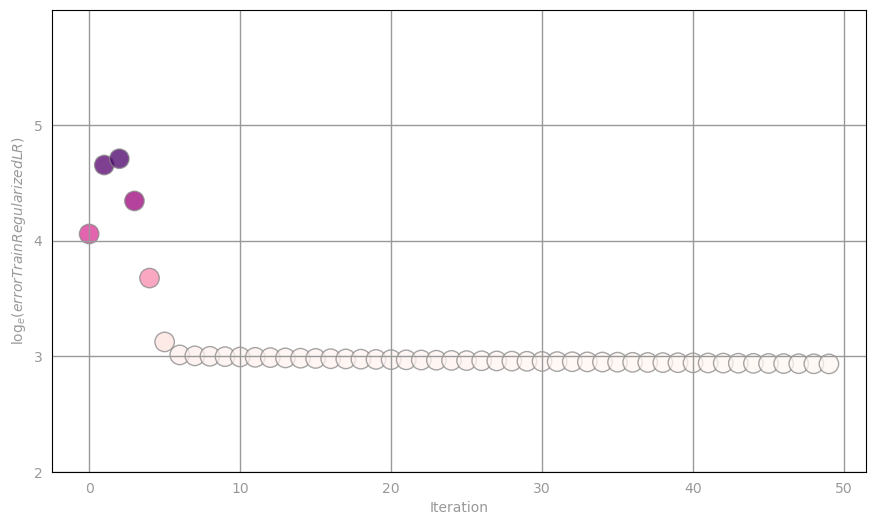

In [26]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(errorTrainRegularizedLR))))[:,0:5]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, numIters), np.log(errorTrainRegularizedLR), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainRegularizedLR)$')
plt.show()

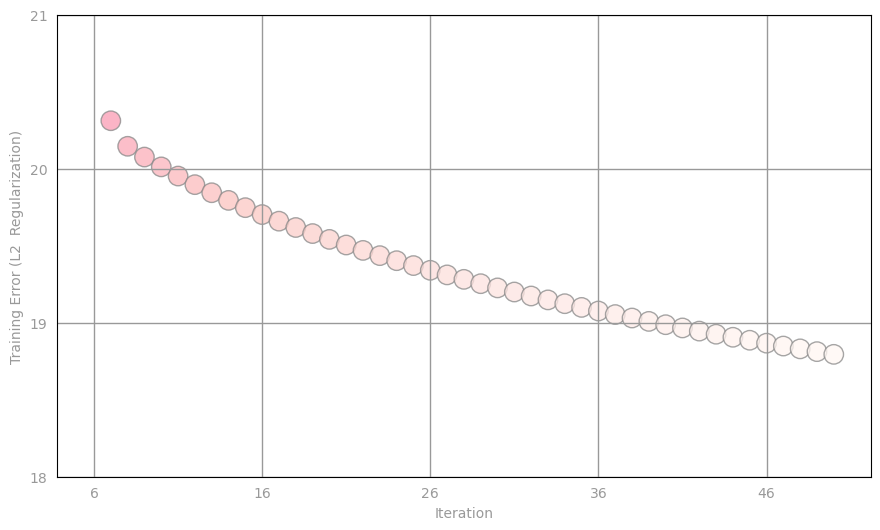

In [27]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainRegularizedLR[5:])))[:,0:5]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(18, 21)
plt.scatter(range(0, numIters-5), errorTrainRegularizedLR[5:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error (L2  Regularization)')
plt.show()

### ** Part 5: Train using MLlib and perform grid search **

#### **(5a) `LinearRegressionWithSGD` **
#### We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization (which we briefly explored earlier), and (based on the previous visualization) training for more iterations.  MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionWithSGD.html) essentially implements the same algorithm that we implemented in Part (3b), albeit more efficiently and with various additional functionality, such as stochastic gradient approximation, including an intercept in the model and also allowing L1 or L2 regularization.  First use LinearRegressionWithSGD to train a model with L2 regularization and with an intercept.  This method returns a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionModel.html#pyspark.mllib.regression.LinearRegressionModel).  Next, use the model's [weights](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearModel.html#pyspark.mllib.regression.LinearModel.weights) and [intercept](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearModel.html#pyspark.mllib.regression.LinearModel.intercept) attributes to print out the model's parameters.

In [28]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 300  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [29]:
# TODO: Replace <FILL IN> with appropriate code
firstModel = LinearRegressionWithSGD.train(data=parsedTrainData, iterations=numIters, step=alpha,
                                          miniBatchFraction=miniBatchFrac, regParam=reg, regType=regType,
                                          intercept=useIntercept)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print (weightsLR1, interceptLR1)

23/04/06 22:38:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/06 22:38:00 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


[15.86892327968764,14.062508209790796,0.662651220305363,6.166313569875225,3.932109243311619,-2.251854136261459,10.43360013502342,3.0609184541059027,7.2238086604017235,4.606574229897507,7.8494178808086605,3.0480301467725064] 13.373068603347885


#### **(5b) Predict**
#### Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point.  Pass the `features` from a `LabeledPoint` into the `predict()` method.

In [30]:
# TODO: Replace <FILL IN> with appropriate code
samplePoint = parsedTrainData.take(1)[0]
samplePrediction = firstModel.predict(samplePoint.features)
print (samplePrediction)

56.35312158912849


#### ** (5c) Evaluate RMSE **
#### Next evaluate the accuracy of this model on the validation set.  Use the `predict()` method to create a `labelsAndPreds` RDD, and then use the `calcRMSE()` function from Part (2b).

In [31]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPreds = parsedValData.map(lambda lp:(lp.label, firstModel.predict(lp.features)))
rmseValLR1 = calcRMSE(labelsAndPreds)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1))

Validation RMSE:
	Baseline = 21.475
	LR0 = 18.835
	LR1 = 19.581


#### ** (5d) Grid search **
#### We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-6`, `1e-3`, and `1`.

In [32]:
# TODO: Replace <FILL IN> with appropriate code
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in [1e-6, 1e-3, 1]:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print (rmseValGrid)

    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model
rmseValLRGrid = bestRMSE

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tRegularizedLR = {3:.3f}\n\tLRGrid = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValRegularizedLR, rmseValLRGrid))

17.232174978991218


17.278743848913525
23.589738514229982
Validation RMSE:
	Baseline = 21.475
	LR0 = 18.835
	LR1 = 19.581
	RegularizedLR = 18.835
	LRGrid = 17.232


#### ** Visualization 6: Best model's predictions**
#### Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 3 using the predictions from the best model from Part (5d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

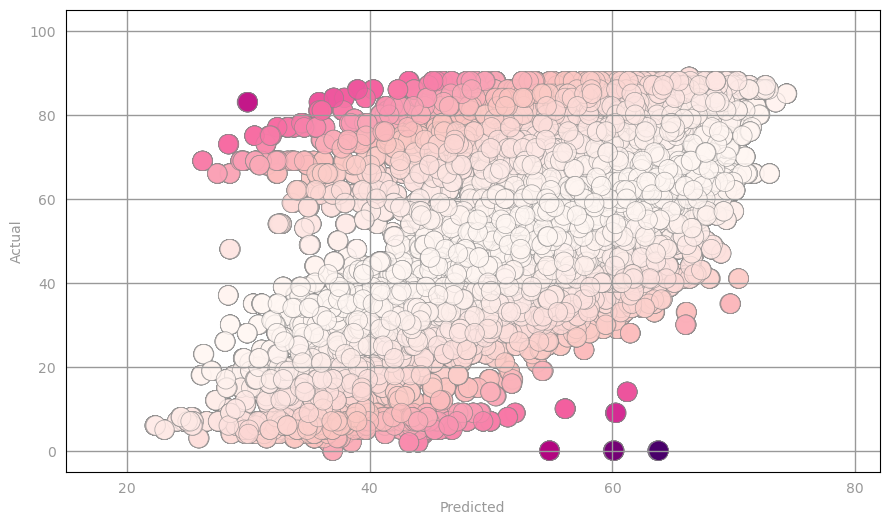

In [33]:
predictions = np.asarray(parsedValData
                         .map(lambda lp: bestModel.predict(lp.features))
                         .collect())
actual = np.asarray(parsedValData
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsedValData
                   .map(lambda lp: squaredError(lp.label, bestModel.predict(lp.features)))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:5]

fig, ax = preparePlot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
plt.show()

#### ** (5e) Vary alpha and the number of iterations **
#### In the previous grid search, we set `alpha = 1` for all experiments.  Now let's see what happens when we vary `alpha`.  Specifically, try `1e-3` and `10` as values for `alpha` and also try training models for 500 iterations (as before) but also for 5 iterations. Evaluate all models on the validation set.  Note that if we set `alpha` too small the gradient descent will require a huge number of steps to converge to the solution, and if we use too large of an `alpha` it can cause numerical problems, like you'll see below for `alpha = 10`.

In [34]:
# TODO: Replace <FILL IN> with appropriate code
reg = bestRegParam
modelRMSEs = []

for alpha in [1e-3, 10]:
    for numIters in [5, 500]:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print ('alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal))
        modelRMSEs.append(rmseVal)

alpha = 1e-03, numIters = 5, RMSE = 56.338


alpha = 1e-03, numIters = 500, RMSE = 50.025


alpha = 1e+01, numIters = 5, RMSE = 353122607.155


alpha = 1e+01, numIters = 500, RMSE = 13255810498641763711319978418623507846788145861915257667869603122498551985381894386522834297665203136731478408801476935680.000


#### **Visualization 7: Hyperparameter heat map **
#### Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

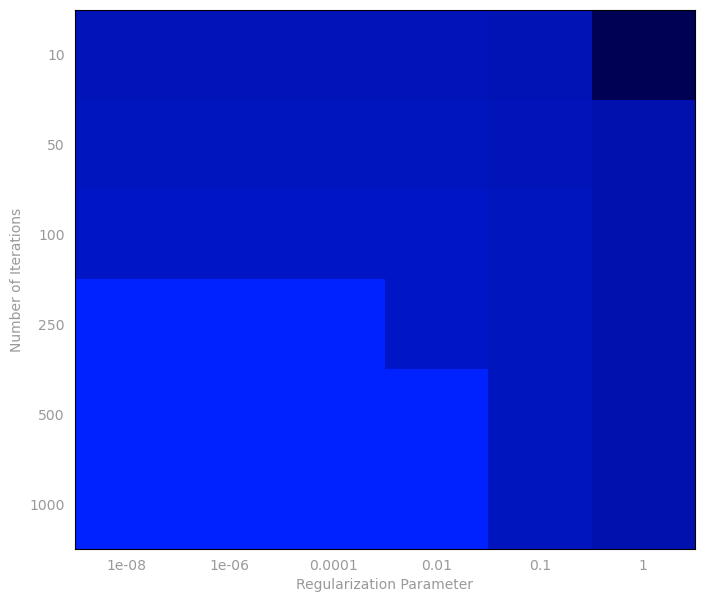

In [35]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)
plt.show()

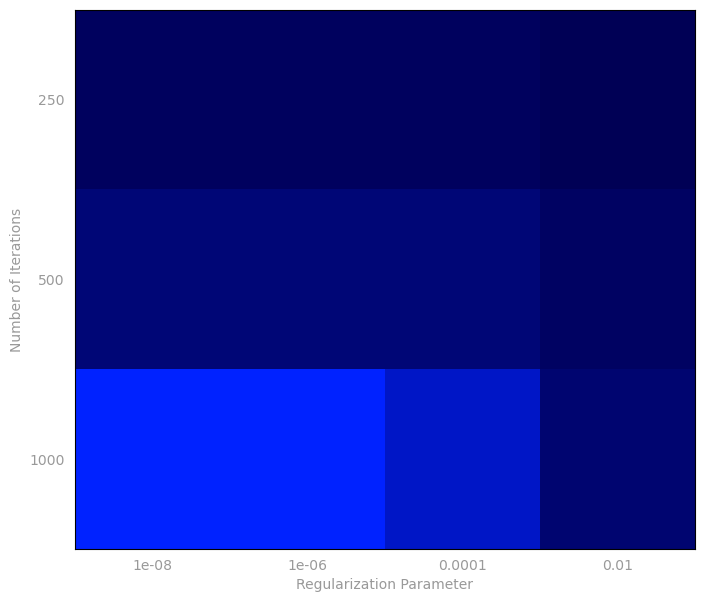

In [36]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = preparePlot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
plt.show()

### ** Part 6: Add interactions between features **

#### ** (6a) Add 2-way interactions **
#### So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `twoWayInteractions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.  Note that a dataset with three features would have nine ( 3^2 ) two-way interactions.
#### You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.  Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [37]:
# TODO: Replace <FILL IN> with appropriate code
import itertools

def twoWayInteractions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    features = lp.features
    interactions = [f1*f2 for f1, f2 in itertools.product(features, repeat=2)]
    return LabeledPoint(lp.label, np.hstack((features, interactions)))

print (twoWayInteractions(LabeledPoint(1.0, [3, 5])))

# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = parsedTrainData.map(twoWayInteractions)
valDataInteract = parsedValData.map(twoWayInteractions)
testDataInteract = parsedTestData.map(twoWayInteractions)

(1.0,[3.0,5.0,9.0,15.0,15.0,25.0])


#### ** (6b) Build interaction model **
#### Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.  Remember that we should build our model from the training data and evaluate it on the validation data.
####  Note that you should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.  For this exercise, we have already preset the hyperparameters to reasonable values.

In [38]:
# TODO: Replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(trainDataInteract, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = valDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1,
                                                 rmseValLRGrid, rmseValInteract))

Validation RMSE:
	Baseline = 21.475
	LR0 = 18.835
	LR1 = 19.581
	LRGrid = 17.232
	LRInteract = 16.042


#### ** (6c) Evaluate interaction model on test data **
#### Our final step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.
#### We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [39]:
# TODO: Replace <FILL IN> with appropriate code
labelsAndPredsTest = testDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseTestInteract = calcRMSE(labelsAndPredsTest)

print (('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmseTestBase, rmseTestInteract)))

Test RMSE:
	Baseline = 21.349
	LRInteract = 15.989
